In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev_cands = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()

In [9]:
import bz2
from six.moves.cPickle import load

# with bz2.BZ2File('data/ctd.pkl.bz2', 'rb') as ctd_f:
#     ctd_unspecified, ctd_therapy, ctd_marker = load(ctd_f)
    
    
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker else 0

def LF_in_ctd_unspecified(c):
    if(cand_in_ctd_unspecified(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_therapy(c):
    if(cand_in_ctd_therapy(c)==1):
        return (-1,1)
    else:
        return (0,0)

def LF_in_ctd_marker(c):
    if(cand_in_ctd_marker(c)==1):
        return (1,1)
    else:
        return (0,0)

In [61]:
from __future__ import division

def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    #print("LF_CHEM",len(sent.words),dis_end + dist // 2)
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    for i in range(max(0, dis_start - dist // 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return (-1,1)
    return (0,0)

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return (-1,1)
    return (0,0)

In [12]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=1, annotator='gold')

from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

AnnotatorLabels created: 0


<888x1 sparse matrix of type '<type 'numpy.int64'>'
	with 888 stored elements in Compressed Sparse Row format>

In [13]:
#gold_labels_dev = [x[0,0] for x in L_gold_dev.todense()]
#for i,L in enumerate(gold_labels_dev):
#    print(i,gold_labels_dev[i])

gold_labels_dev = []
for i,L in enumerate(L_gold_dev):
    gold_labels_dev.append(L[0,0])
    
    
print(len(gold_labels_dev))
print(gold_labels_dev.count(1),gold_labels_dev.count(-1))

888
296 592


In [30]:
from gensim.parsing.preprocessing import STOPWORDS
import gensim.matutils as gm

from gensim.models.keyedvectors import KeyedVectors

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = KeyedVectors.load_word2vec_format('../glove_w2v.txt', binary=False)  # C binary format


wordvec_unavailable= set()
def write_to_file(wordvec_unavailable):
    with open("wordvec_unavailable.txt","w") as f:
        for word in wordvec_unavailable:
            f.write(word+"\n")

def preprocess(tokens):
    btw_words = [word for word in tokens if word not in STOPWORDS]
    btw_words = [word for word in btw_words if word.isalpha()]
    return btw_words

def get_word_vectors(btw_words): # returns vector of embeddings of words
    word_vectors= []
    for word in btw_words:
        try:
            word_v = np.array(model[word])
            word_v = word_v.reshape(len(word_v),1)
            #print(word_v.shape)
            word_vectors.append(model[word])
        except:
            wordvec_unavailable.add(word)
    return word_vectors

def get_similarity(word_vectors,target_word): # sent(list of word vecs) to word similarity
    similarity = 0
    target_word_vector = 0
    try:
        target_word_vector = model[target_word]
    except:
        wordvec_unavailable.add(target_word+" t")
        return similarity
    target_word_sparse = gm.any2sparse(target_word_vector,eps=1e-09)
    for wv in word_vectors:
        wv_sparse = gm.any2sparse(wv, eps=1e-09)
        similarity = max(similarity,gm.cossim(wv_sparse,target_word_sparse))
    return similarity


In [42]:
# ##### Continuous ################

# softmax_Threshold = 0.3
# LF_Threshold = 0.3

# import re
# from snorkel.lf_helpers import (
#     get_left_tokens, get_right_tokens, get_between_tokens,
#     get_text_between, get_tagged_text,
# )

# import re
# from snorkel.lf_helpers import (
#     get_tagged_text,
#     rule_regex_search_tagged_text,
#     rule_regex_search_btw_AB,
#     rule_regex_search_btw_BA,
#     rule_regex_search_before_A,
#     rule_regex_search_before_B,
# )

# def ltp(x):
#     return '(' + '|'.join(x) + ')'

# causal = ['induced', 'caused', 'due','associated with']

# def LF_induce(c):
#     return (1,1) if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

# def LF_causal(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_between_tokens(c))
#     for w in causal:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('{{A}}.{0,50}(not|no|none).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (1,sc)
    
# def LF_induce_name(c):
#     return (1,1) if 'induc' in c.chemical.get_span().lower() else (0,0)   

    
# def LF_c_induced_d(c):
#     return (1,1) if (
#         ('{{A}} {{B}}' in get_tagged_text(c)) and 
#         (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
#         ) else (0,0)

    
# treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']

# def LF_treat(c):
#     global LF_Threshold
#     sc = 0
#     word_vectors = get_word_vectors(get_between_tokens(c))
#     for w in treat:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('{{A}}.{0,50}(not|no|none).{0,20}' + ltp(treat) + '.{0,50}{{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (-1,sc)
    
# def LF_treat_d(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     for w in treat:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('(not|no|none) .{0,50} {{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (-1,sc)
    
# def LF_c_d(c):
#     return (1,1) if ('{{A}} {{B}}' in get_tagged_text(c)) else (0,0)

    
# pat_terms = ['in a patient with ', 'in patients with']
# def LF_in_patient_with(c):
#     return (-1,1) if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

# uncertain = ['combin', 'possible', 'unlikely']

# def LF_uncertain(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     for w in uncertain:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('(not|no|none) .{0,50} {{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (-1,sc)
    
# def LF_far_c_d(c):
#     if(rule_regex_search_btw_AB(c, '.{100,5000}', -1)==-1):
#         return (-1,1)
#     else:
#         return (0,0)

# def LF_far_d_c(c):
#     if(rule_regex_search_btw_BA(c, '.{100,5000}', -1)==-1):
#         return (-1,1)
#     else:
#         return (0,0)
    
# def LF_develop_d_following_c(c):
#     sc1 = 0
#     sc2 = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     sc1=max(sc1,get_similarity(word_vectors,'develop'))
    
#     word_vectors = get_word_vectors(get_between_tokens(c))
#     sc2=max(sc2,get_similarity(word_vectors,'following'))
    
#     sc = (sc1+sc2)/2
#     if(re.search('(not|no|none) .{0,50} {{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (1,sc)
    

# def LF_risk_d(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     sc=max(sc,get_similarity(word_vectors,'risk'))
#     if(re.search(' (not|no|none) .{0,50}{{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (1,sc)
    
# def LF_improve_before_disease(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     sc=max(sc,get_similarity(word_vectors,'improve'))
#     for nw in Not:
#         if nw in get_between_tokens(c):
#             return (0,0)
#     else:
#         return (1,sc)
    
# procedure, following = ['inject', 'administrate'], ['following']
# def LF_d_following_c(c):
#     sc1 = 0
#     sc2 = 0
#     word_vectors = get_word_vectors(get_between_tokens(c))
#     for w in following:
#         sc1=max(sc1,get_similarity(word_vectors,w))
    
#     word_vectors = get_word_vectors(get_right_tokens(c[1]))
#     for w in procedure:
#         sc2=max(sc2,get_similarity(word_vectors,w))
    
#     sc = (sc1+sc2)/2
#     return (1,sc)

# def LF_measure(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[0]))
#     sc=max(sc,get_similarity(word_vectors,'measure'))
#     return (-1,sc)
    
# def LF_level(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_right_tokens(c[0]))
#     sc=max(sc,get_similarity(word_vectors,'level'))
#     return (-1,sc)

# def LF_neg_d(c):
#     return (-1,1) if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

    
# WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
#                 'seems', 'suggests', 'risk', 'implicated',
#                'aim', 'investigate','assess','study']


# def LF_weak_assertions(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1]))
#     for w in WEAK_PHRASES:
#         sc=max(sc,get_similarity(word_vectors,w))
#     for nw in Not:
#         if nw in get_between_tokens(c):
#             return (0,0)
#     else:
#         return (-1,sc)


In [153]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return (1,1) if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1),1)

# def LF_d_induced_by_c(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_between_tokens(c))
#     for w in causal_past:
#         sc=max(sc,get_similarity(word_vectors,w))
#     return (1,sc)

def LF_d_induced_by_c_tight(c):
    return (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1),1)

def LF_induce_name(c):
    return (1,1) if 'induc' in c.chemical.get_span().lower() else (0,0)     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return (1,1) if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else (0,0)

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return (rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1),1)
def LF_c_treat_d(c):
    return (rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1),1)

def LF_treat_d(c):
    return (rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1),1)


# def LF_treat_d(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1],5))
#     for w in treat:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('(not|no|none) .{0,50} {{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (-1,sc)
    
def LF_c_treat_d_wide(c):
    return (rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1),1)

def LF_c_d(c):
    return (1,1) if ('{{A}} {{B}}' in get_tagged_text(c)) else (0,0)

def LF_c_induced_d(c):
    return (1,1) if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else (0,0)

def LF_improve_before_disease(c):
    return (rule_regex_search_before_B(c, 'improv.*', -1),1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return (-1,1) if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return (rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1),1)

# def LF_uncertain(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1],5))
#     for w in uncertain:
#         sc=max(sc,get_similarity(word_vectors,w))
#     if(re.search('(not|no|none) .{0,50} {{B}}', get_tagged_text(c), re.I)):
#         return (0,0)
#     else:
#         return (-1,sc)
    
def LF_induced_other(c):
    return (rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1),1)

def LF_far_c_d(c):
    return (rule_regex_search_btw_AB(c, '.{100,5000}', -1),1)

def LF_far_d_c(c):
    return (rule_regex_search_btw_BA(c, '.{100,5000}', -1),1)

def LF_risk_d(c):
    return (rule_regex_search_before_B(c, 'risk of ', 1),1)


# def LF_risk_d(c):
#     sc = 0
#     word_vectors = get_word_vectors(get_left_tokens(c[1],5))
#     sc=max(sc,get_similarity(word_vectors,'risk'))
#     return (1,sc)

def LF_develop_d_following_c(c):
    return (1,1) if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return (1,1) if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else (0,0)

def LF_measure(c):
    return (-1,1) if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else (0,0)

def LF_level(c):
    return (-1,1) if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else (0,0)

def LF_neg_d(c):
    return (-1,1) if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else (0,0)

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return (-1,1) if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else (0,0)


In [43]:
# def LF_ctd_marker_c_d(c):
#     l,s = LF_c_d(c)
#     return (l*cand_in_ctd_marker(c),s)

# def LF_ctd_marker_induce(c):
#     l,s = LF_c_induced_d(c)
#     return (l*cand_in_ctd_marker(c),s)

# def LF_ctd_therapy_treat(c):
#     l,s = LF_treat(c)
#     return (l* cand_in_ctd_therapy(c),s)

# def LF_ctd_unspecified_treat(c):
#     l,s = LF_treat(c)
#     return (l * cand_in_ctd_unspecified(c),s)

# def LF_ctd_unspecified_induce(c):
#     l,s = LF_c_induced_d(c)
#     return (l*cand_in_ctd_unspecified(c),s)


In [154]:
def LF_ctd_marker_c_d(c):
    l,s = LF_c_d(c)
    return (l*cand_in_ctd_marker(c),s)

def LF_ctd_marker_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    return ((l1 or l2) * cand_in_ctd_marker(c),(s1*s2))

def LF_ctd_therapy_treat(c):
    l,s = LF_c_treat_d_wide(c)
    return (l* cand_in_ctd_therapy(c),s)

def LF_ctd_unspecified_treat(c):
    l,s = LF_c_treat_d_wide(c)
    return (l* cand_in_ctd_unspecified(c),s)

def LF_ctd_unspecified_induce(c):
    l1,s1 = LF_c_induced_d(c)
    l2,s2 = LF_d_induced_by_c_tight(c)
    return ((l1 or l2) * cand_in_ctd_unspecified(c),(s1*s2))

In [44]:
# import numpy as np
# import math

# LFs = [LF_in_ctd_unspecified,LF_in_ctd_marker,LF_in_ctd_therapy,LF_closer_chem, 
#        LF_closer_dis,LF_causal,LF_c_induced_d,LF_c_d,LF_in_patient_with,LF_uncertain,
#        LF_far_c_d,LF_far_d_c,LF_develop_d_following_c,LF_d_following_c,LF_measure,
#       LF_level,LF_neg_d,LF_weak_assertions,LF_ctd_marker_c_d,LF_ctd_therapy_treat,
#       LF_ctd_unspecified_treat,LF_ctd_unspecified_induce,LF_improve_before_disease,
#        LF_risk_d,LF_treat,LF_treat_d,LF_induce,LF_induce_name]


In [155]:
import numpy as np
import math

import matplotlib.pyplot as plt

LFs = [
    LF_c_cause_d,
    LF_c_d,
    LF_c_induced_d,
    LF_c_treat_d,
    LF_c_treat_d_wide,
    LF_closer_chem,
    LF_closer_dis,
    LF_ctd_marker_c_d,
    LF_ctd_marker_induce,
    LF_ctd_therapy_treat,
    LF_ctd_unspecified_treat,
    LF_ctd_unspecified_induce,
    LF_d_following_c,
    LF_d_induced_by_c,
    LF_d_induced_by_c_tight,
    LF_d_treat_c,
    LF_develop_d_following_c,
    LF_far_c_d,
    LF_far_d_c,
    LF_improve_before_disease,
    LF_in_ctd_therapy,
    LF_in_ctd_marker,
    LF_in_patient_with,
    LF_induce,
    LF_induce_name,
    LF_induced_other,
    LF_level,
    LF_measure,
    LF_neg_d,
    LF_risk_d,
    LF_treat_d,
    LF_uncertain,
    LF_weak_assertions
]

In [36]:
''' output:

    [[[L_x1],[S_x1]],
     [[L_x2],[S_x2]],
     ......
     ......
    ]

'''
def get_L_S_Tensor(cands): 
    
    L_S = []
    for ci in cands:
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
    return L_S

def get_L_S(cands):  # sign gives label abs value gives score
    
    L_S = []
    for ci in cands:
        l_s=[]
        for LF in LFs:
            #print LF.__name__
            l,s = LF(ci)
            s= (s+1)/2  #to scale scores in [0,1] 
            l_s.append(l*s)
        L_S.append(l_s)
    return L_S

def get_Initial_P_cap_L_S(L_S):
    P_cap = []
    for L,S in L_S:
        P_ik = []
        denominator=float(L.count(1)+L.count(-1))
        if(denominator==0):
            denominator=1
        P_ik.append(L.count(1)/denominator)
        P_ik.append(L.count(-1)/denominator)
        P_cap.append(P_ik)
    return P_cap



In [156]:
# import matplotlib.pyplot as plt
   
from sklearn.metrics import precision_recall_fscore_support

import cPickle as pkl

dev_L_S = get_L_S_Tensor(dev_cands)
train_L_S = get_L_S_Tensor(train_cands)
# test_L_S = get_L_S_Tensor(test_cands)


# train_P_cap= get_Initial_P_cap_L_S(train_L_S) 

# dev_P_cap = get_Initial_P_cap_L_S(dev_L_S)

# test_P_cap = get_Initial_P_cap_L_S(test_L_S)

import cPickle as pkl

pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
pkl.dump(train_L_S,open("train_L_S.p","wb"))
# pkl.dump(test_L_S,open("test_L_S.p","wb"))

# pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
# pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
# pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

In [89]:
#prepare batch data
# train_L_S_batch,dev_L_S_batch = get_L_S_batch()
# train_P_cap_batch,dev_P_cap_batch = get_P_cap_batch()

In [2]:
from sklearn.metrics import precision_recall_fscore_support

import cPickle as pkl


# pkl.dump(dev_L_S,open("dev_L_S.p","wb"))
# pkl.dump(train_L_S,open("train_L_S.p","wb"))
#pkl.dump(test_L_S,open("test_L_S.p","wb"))

#pkl.dump(train_P_cap,open("train_P_cap.p","wb"))
#pkl.dump(dev_P_cap,open("dev_P_cap.p","wb"))
#pkl.dump(test_P_cap,open("test_P_cap.p","wb"))

dev_L_S = pkl.load( open( "dev_L_S.p", "rb" ) )
train_L_S = pkl.load( open( "train_L_S.p", "rb" ) )
# test_L_S = pkl.load( open( "test_L_S.p", "rb" ) )

# train_P_cap = pkl.load( open( "train_P_cap.p", "rb" ) )
# dev_P_cap = pkl.load( open( "dev_P_cap.p", "rb" ) )
# test_P_cap = pkl.load( open( "test_P_cap.p", "rb" ) )

def get_L_S_batch():
    dev_L_batch = []
    dev_S_batch = []
    dev_L_S_batch = []
    train_L_batch = []
    train_S_batch = []
    train_L_S_batch = []
    for l,s in train_L_S:
        train_L_batch.append(l)
        train_S_batch.append(s)
    train_L_S_batch = [train_L_batch, train_S_batch]
    for l,s in dev_L_S:
        dev_L_batch.append(l)
        dev_S_batch.append(s)
    dev_L_S_batch = [dev_L_batch, dev_S_batch]
    return train_L_S_batch,dev_L_S_batch


def get_P_cap_batch():
    kp1_train= []
    kn1_train = []
    kp1_dev= []
    kn1_dev = []
    for pci in train_P_cap:
        kp1_train.append(pci[0])
        kn1_train.append(pci[1])
    for pci in dev_P_cap:
        kp1_dev.append(pci[0])
        kn1_dev.append(pci[1])
    return [kp1_train,kn1_train],[kp1_dev,kn1_dev]
        
def get_mini_batches(X,P_cap,bsize): #X : (train/dev/)_L_S_batch
    for i in range(0, len(X[0]) - bsize + 1, bsize):
        indices = slice(i, i + bsize)
        #print(indices)
        yield [X[0][indices],X[1][indices]],P_cap[indices]

# train_L_S_batch,dev_L_S_batch = get_L_S_batch()

#for x in get_mini_batches(train_L_S_batch,200):
#    print(len(x),len(x[0]),len(x[0][0]))
    


In [171]:
#All discrete snorkel Obj + removed alphas
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

#     alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(1,0.1,1217),
#                             dtype=tf.float64)

#     alphas = tf.constant([0],dtype=tf.float64,shape=len(LFs))
    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(2,1,12),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

#     prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = l

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            t,te_curr,_ = sess.run([thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

#             if(abs(te_curr-te_prev)<1e-200):
#                 print("too low")
#                 break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    t,de_curr,p = sess.run([thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/100)
                total_te=0
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -3.60517677736
-0.0865666342491
[ 3.17544629  0.14214532  2.09559654  2.00634306  3.0638787   2.41338549
  3.69205997  2.31207849  3.46334713  2.64733297  1.83570643  2.66614047
  1.82381844  2.78581588  2.40812473  2.42236116  0.53341341  1.19934539
  2.59624823  0.36416023  2.35386239  1.41425373  1.96214684  3.63011132
  0.73733434  3.77477556  2.6808572   2.68507779  2.57476273  1.90343721
  0.21991559  0.38377467  1.62150535]

602 286
0  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.60615247481
-2.9584399638
[ 3.17570043  0.14264532  2.09609654  2.00654305  3.06437869  2.41458216
  3.69205997  2.31257849  3.46404713  2.64753297  1.83590643  2.66674047
  1.82381844  2.78660941  2.40842472  2.42236116  0.53341341  1.19979384
  2.59769944  0.36416023  2.35484227  1.41572046  1.96214684  3.63029681
  0.73794878  3.77497554  2.6808572   2.6850738   2.57506025  1.90337955
  0.21983238  0.38377467  1.6216291 ]

602 286
100  d  (0.6873940013

dev err: -3.62961459819
-3.60372938017
[ 3.17910342  0.15551621  2.10639601  2.01593976  3.07925966  2.43869423
  3.694357    2.32510422  3.47614713  2.65603297  1.84550573  2.67674046
  1.82411755  2.79082648  2.41082471  2.42752129  0.53350954  1.21009442
  2.60905997  0.36435147  2.39024006  1.431047    1.96214684  3.63210903
  0.74825395  3.77976936  2.68104209  2.68510043  2.57661063  1.90344162
  0.2215097   0.38579574  1.63136575]

602 286
1600  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.63066623398
-3.25962385308
[ 3.17980333  0.15571613  2.10649601  2.01613975  3.07955948  2.44084626
  3.69455484  2.32530414  3.47674713  2.65603297  1.84580554  2.67734046
  1.82411755  2.79190537  2.41132471  2.42804923  0.53350954  1.21019207
  2.61080535  0.36435147  2.39091782  1.43149065  1.96214684  3.63270898
  0.74835395  3.77976936  2.68114116  2.68510043  2.57669221  1.90344162
  0.22126592  0.38581769  1.63219973]

602 286
1700  d  (0.68739400

dev err: -3.65385103993
-3.0417076459
[ 3.18306429  0.16930397  2.1177941   2.02295266  3.09136286  2.47081322
  3.69674206  2.33824693  3.48994713  2.66173297  1.85341511  2.68794046
  1.82411755  2.79621286  2.4141247   2.43170011  0.53354221  1.22171813
  2.62297117  0.36435147  2.4207447   1.44470786  1.96244041  3.63566107
  0.75791077  3.78706014  2.68279559  2.68539887  2.57843199  1.90378167
  0.22222332  0.38636307  1.64104679]

602 286
3200  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.65567075994
-4.29047286134
[ 3.18316427  0.17071383  2.1190941   2.02315266  3.09186267  2.47270087
  3.69674206  2.33974678  3.49134713  2.66213297  1.85381492  2.68874046
  1.82411755  2.79651208  2.4142247   2.43197568  0.53354221  1.22294765
  2.62366972  0.36435147  2.42292379  1.44586449  1.96244041  3.63566107
  0.75862828  3.78795823  2.68279559  2.68539887  2.57871311  1.90378167
  0.22234508  0.38636307  1.64241623]

602 286
3300  d  (0.687394001

dev err: -3.67820206916
-2.91997017934
[ 3.1870207   0.18563581  2.13099282  2.02925232  3.10272957  2.4981415
  3.70193814  2.35402727  3.50394713  2.66753296  1.85981451  2.69924045
  1.82421726  2.7994446   2.4156247   2.43545689  0.53359672  1.2381852
  2.63616273  0.36438637  2.45158202  1.46050849  1.96292659  3.63745308
  0.76907863  3.79374654  2.68416829  2.68577958  2.58054049  1.90363635
  0.22438356  0.38714339  1.65151524]

602 286
4800  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.67944049416
-3.5530666023
[ 3.18721826  0.18634547  2.13149282  2.0301523   3.10432919  2.50004316
  3.70213795  2.35471856  3.50444713  2.66823296  1.86061415  2.69964045
  1.82421726  2.79963413  2.4156247   2.43563045  0.53359672  1.23913928
  2.63636259  0.36438637  2.45242931  1.46306422  1.96292659  3.63775281
  0.76968023  3.79403811  2.68416829  2.68577958  2.58054049  1.90363635
  0.22429911  0.38714339  1.65184999]

602 286
4900  d  (0.68739400134

dev err: -3.70235733601
-3.70375898682
[ 3.19334877  0.19825932  2.1415924   2.03724791  3.11792284  2.52206073
  3.70453632  2.36631762  3.51784713  2.67583296  1.86941406  2.71024045
  1.82421726  2.80597573  2.41942469  2.43926643  0.53365218  1.25327163
  2.64385287  0.36428637  2.48811345  1.47216206  1.96302659  3.64019902
  0.77953607  3.7992286   2.68446643  2.68606318  2.58320148  1.90378109
  0.22615913  0.38783725  1.65964576]

602 286
6400  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.70440031892
-4.77495549433
[ 3.19344876  0.19884888  2.1418924   2.03804791  3.11982224  2.52395371
  3.70453632  2.36690719  3.51824713  2.67763296  1.87061406  2.71054045
  1.82421726  2.80627563  2.41952469  2.44006078  0.53365218  1.25496842
  2.64539488  0.36428637  2.49129166  1.47144973  1.96302659  3.64019902
  0.7797368   3.79982787  2.6845655   2.68606318  2.5839805   1.90378109
  0.22605919  0.38853725  1.66052475]

602 286
6500  d  (0.68739400

dev err: -3.72788181234
-3.46397383145
[ 3.19674477  0.212064    2.1520909   2.04289165  3.13176384  2.55001623
  3.70643271  2.37954     3.53114713  2.68363296  1.8789119   2.72104045
  1.82421726  2.81254049  2.42272469  2.44335448  0.53361153  1.27000863
  2.65905101  0.36511658  2.52345601  1.48184267  1.9632882   3.64341354
  0.78768145  3.8079106   2.68622455  2.68682974  2.58669367  1.90363185
  0.22762533  0.38940935  1.6705904 ]

602 286
8000  d  (0.68739400134748974, 0.6841216216216216, 0.68564471843754848, None)
dev err: -3.73019469906
-5.33904634792
[ 3.19690171  0.21326377  2.1528909   2.04369165  3.13356384  2.55175012
  3.70643271  2.38073977  3.53204713  2.68523296  1.8803119   2.72184045
  1.82421726  2.812764    2.42282469  2.44335448  0.53361153  1.2713831
  2.65923366  0.36511658  2.52769015  1.48395465  1.9632882   3.64362431
  0.78850046  3.80861053  2.68622455  2.68682974  2.58679363  1.90381931
  0.22780017  0.39040818  1.67118087]

602 286
8100  d  (0.687394001

In [116]:
#All discrete except LF_Uncertain, LF_Treat_d class- weighted
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN(weight):
    print("weight:",weight)
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(0,1,1324),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(2,0.2,1324),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    

    
    class_weights = tf.constant([weight, 1.0 - weight],dtype=tf.float64)
   
    weighted_phi_out = tf.multiply(phi_out, class_weights) 
    
    predict = tf.argmax(tf.nn.softmax(weighted_phi_out))
    
    loss = tf.negative(tf.reduce_logsumexp(weighted_phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
#                 print("dev err:",t_de/888)
#                 print(total_te/100)
                total_te=0
#                 print(a)
#                 print(t)
#                 print()
#                 print(predicted_labels.count(-1),predicted_labels.count(1))
#                 print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
#         print(predicted_labels.count(-1),predicted_labels.count(1))
#         print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
        p,r,f,_ = precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro')
        return (p,r)
#train_NN()

In [117]:
#All discrete except LF_d_induced_by_c + seed
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(1,0.1,12),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(2,0.2,12),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/100)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -0.712200279855
-0.00699214594392
[ 1.11754463  0.81421453  1.00955965  1.00062431  1.10637787  1.04133855
  1.169206    1.03120785  1.14633471  1.0647233   0.98357064  1.06661405
  0.98238184  1.07858159  1.04081247  1.04223612  0.85334134  0.91993454
  1.05962482  0.83641602  1.03537624  0.94141469  0.99621468  1.16301113
  0.87373343  1.17747756  1.06808572  1.06850778  1.05747627  0.99034372
  0.82199156  0.83837747  0.96215054]
[ 2.23508926  1.62842906  2.01911931  2.00124861  2.21275574  2.0826771
  2.33841199  2.0624157   2.29266943  2.12944659  1.96714129  2.13322809
  1.96476369  2.15716318  2.08162495  2.08447223  1.70668268  1.83986908
  2.11924965  1.67283205  2.07075248  1.88287139  1.99242937  2.32602226
  1.74746687  2.35495511  2.13617144  2.13701556  2.11495255  1.98068744
  1.64398312  1.67675493  1.92430107]

433 455
0  d  (0.74865111793518258, 0.77956081081081074, 0.73813646844857261, None)
too low
0 -5.85618950661
433 455
(0.74865111793518258, 0.779560810

In [115]:
#All discrete except  LF_d_induced_by_c
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(1,0.5),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(2,0.2),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

#             if(abs(te_curr-te_prev)<1e-500):
#                 print("too low")
#                 break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/100)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -1.24021594516
-0.00727557153698
[ 1.45309696  0.50320698  0.94080156  0.90309973  1.03868911  0.88252105
  1.9354867   0.57699021  0.80978554  0.86382682  0.75725263  0.5197248
  1.32525436  1.6446386   0.31114999  1.04398013  0.52422312  0.56656603
  0.19475854  1.84275192  1.41456737  0.64538208  0.68120582  0.69057477
  0.78813229  1.14112276  0.10069783  1.14008761  1.13385635  0.65993288
  1.5642177   1.47902347  0.31614432]
[ 1.99650432  2.02515512  2.05408972  1.89038642  1.96081336  2.00640417
  2.14163455  1.89173431  1.8058507   2.35849196  2.11823934  1.82639625
  1.90415227  2.03547824  1.95720776  2.10167143  1.83733515  1.83137145
  1.80427967  1.61069282  2.02374461  2.16724976  2.03177096  1.87350118
  2.24070905  1.75384483  1.66788193  2.03053148  1.9448893   2.04635225
  1.83142393  2.01946326  2.28138318]

507 381
0  d  (0.69537498641072237, 0.7153716216216216, 0.6980415928002226, None)
dev err: -1.2441279739
-1.17698060804
[ 1.45309696  0.50219495  0.939

dev err: -1.28937450087
-1.37282143264
[ 1.45309696  0.48610692  0.92645119  0.89991233  1.03868911  0.87771855
  1.9354867   0.56156793  0.79769031  0.85878069  0.75218627  0.50931579
  1.32525436  1.6446386   0.30776973  1.04398013  0.52422312  0.56001304
  0.18434975  1.84275192  1.41456737  0.58472099  0.68120582  0.68887457
  0.7662418   1.14112276  0.1005884   1.14008761  1.13385635  0.66020968
  1.5642177   1.47902347  0.30090153]
[ 1.99650432  2.02941687  2.05455266  1.89055237  1.96081336  2.00669056
  2.14163455  1.89524177  1.80716415  2.35878851  2.11882572  1.82916052
  1.90415227  2.03547824  1.95839987  2.10167143  1.83733515  1.83293314
  1.80894868  1.61069282  2.02374461  2.17799451  2.03177096  1.87378266
  2.24288365  1.75384483  1.66794093  2.03053148  1.9448893   2.04630625
  1.83142393  2.01946326  2.28599788]

477 411
900  d  (0.6970343846118533, 0.72043918918918926, 0.69569042966036543, None)
dev err: -1.29525747243
-1.41256724391
[ 1.45309696  0.48367575  0.92

dev err: -1.34075226448
-1.61335233696
[ 1.45309696  0.47208054  0.91597966  0.89587421  1.03868911  0.86283857
  1.9354867   0.54891656  0.78847791  0.85260786  0.74694474  0.50199785
  1.32525436  1.6446386   0.30478287  1.04398013  0.52404917  0.55249719
  0.17174497  1.84275192  1.41456737  0.52818078  0.68120582  0.68633821
  0.74934388  1.14112276  0.10018616  1.14008761  1.13385635  0.66020121
  1.5642177   1.47902347  0.28176861]
[ 1.99650432  2.03301329  2.05495364  1.89077028  1.96081336  2.0076513
  2.14163455  1.89820776  1.80821819  2.35916587  2.11944492  1.83113683
  1.90415227  2.03547824  1.9594575   2.10167143  1.8373802   1.83475149
  1.81466662  1.61069282  2.02374461  2.18947538  2.03177096  1.87420536
  2.24470684  1.75384483  1.66815785  2.03053148  1.9448893   2.04630766
  1.83142393  2.01946326  2.29192058]

477 411
1800  d  (0.6970343846118533, 0.72043918918918926, 0.69569042966036543, None)
dev err: -1.34692528228
-1.37176555738
[ 1.45309696  0.47087132  0.91

dev err: -1.4099478806
-1.60100311001
[ 1.45309696  0.45406672  0.90122769  0.89446884  1.03868911  0.85367887
  1.9354867   0.53373126  0.77618171  0.85002279  0.74408582  0.49052963
  1.32525436  1.6446386   0.30199104  1.04398013  0.52398137  0.54478008
  0.1613689   1.84275192  1.41456737  0.45291501  0.68108998  0.68370777
  0.72694677  1.14112276  0.09893883  1.14008761  1.13385635  0.66030237
  1.5642177   1.47902347  0.27035777]
[ 1.99650432  2.03776443  2.05560891  1.89084808  1.96081336  2.00829706
  2.14163455  1.90187282  1.80969717  2.35932865  2.119788    1.83400862
  1.90415227  2.03547824  1.96044966  2.10167143  1.83739776  1.83664859
  1.81942559  1.61069282  2.02374461  2.20691522  2.03178913  1.87464725
  2.247317    1.75384483  1.66883096  2.03053148  1.9448893   2.04629086
  1.83142393  2.01946326  2.29552149]

443 445
2700  d  (0.69294392167803787, 0.71706081081081074, 0.68390541571319596, None)
dev err: -1.41825065966
-1.37686364281
[ 1.45309696  0.45264337  0.9

dev err: -1.48146709991
-1.58189192553
[ 1.45309696  0.43523742  0.8872555   0.89249251  1.03868911  0.8429056
  1.9354867   0.51740198  0.76441812  0.84604613  0.74092618  0.47983324
  1.32525436  1.6446386   0.29884258  1.04398013  0.52398137  0.53848962
  0.15301561  1.84275192  1.41456737  0.38425398  0.68114428  0.68159803
  0.70695545  1.14112276  0.09787098  1.14008761  1.13385635  0.66019955
  1.5642177   1.47902347  0.25730977]
[ 1.99650432  2.04288863  2.05632694  1.89095925  1.96081336  2.00910976
  2.14163455  1.90594114  1.8111891   2.35958457  2.12017157  1.83639332
  1.90415227  2.03547824  1.96157273  2.10167143  1.83739776  1.83821746
  1.82329066  1.61069282  2.02374461  2.22492707  2.0317806   1.87500427
  2.24983253  1.75384483  1.66940773  2.03053148  1.9448893   2.04630793
  1.83142393  2.01946326  2.29970148]

443 445
3600  d  (0.69294392167803787, 0.71706081081081074, 0.68390541571319596, None)
dev err: -1.49052775106
-1.529337371
[ 1.45309696  0.43266223  0.885

dev err: -1.5663219414
-1.48319032443
[ 1.45309696  0.41689309  0.87348487  0.89014563  1.03868911  0.83468039
  1.9354867   0.50195417  0.7528224   0.84214687  0.73629019  0.46918118
  1.32525436  1.6446386   0.29747887  1.04398013  0.52362116  0.53216883
  0.14297362  1.84275192  1.41456737  0.30840039  0.68079662  0.68020748
  0.6863542   1.14112276  0.09626188  1.14008761  1.13385635  0.66011505
  1.5642177   1.47902347  0.24213885]
[ 1.99650432  2.04803502  2.05712722  1.89109395  1.96081336  2.00976873
  2.14163455  1.90991039  1.81273325  2.35984194  2.12074281  1.83923997
  1.90415227  2.03547824  1.96206054  2.10167143  1.8374911   1.83981403
  1.8279768   1.61069282  2.02374461  2.2470986   2.03183518  1.87524084
  2.25260738  1.75384483  1.67027777  2.03053148  1.9448893   2.04632196
  1.83142393  2.01946326  2.30464495]

433 455
4500  d  (0.70132477222546508, 0.72635135135135132, 0.68968594719236143, None)
dev err: -1.58018585418
-2.05711985438
[ 1.45309696  0.4138207   0.8

dev err: -1.67015692819
-1.77256575264
[ 1.45309696  0.40068064  0.86033257  0.88853336  1.03868911  0.83309565
  1.9354867   0.48819803  0.74176101  0.83833399  0.73397085  0.45634994
  1.32525436  1.6446386   0.29481279  1.04398013  0.52362116  0.52810376
  0.13900788  1.84275192  1.41456737  0.21939095  0.68093713  0.67708154
  0.66838523  1.14112276  0.09626183  1.14008761  1.13385635  0.66026535
  1.5642177   1.47902347  0.23159661]
[ 1.99650432  2.05270905  2.05797732  1.89118815  1.96081336  2.00989909
  2.14163455  1.91354301  1.81427409  2.36009983  2.12103227  1.84239864
  1.90415227  2.03547824  1.9630166   2.10167143  1.8374911   1.84085146
  1.8298393   1.61069282  2.02374461  2.2760656   2.0318131   1.87577629
  2.25517869  1.75384483  1.67027779  2.03053148  1.9448893   2.04629697
  1.83142393  2.01946326  2.30813259]

388 500
5400  d  (0.72734020618556705, 0.75168918918918926, 0.69947697672033637, None)
dev err: -1.68293769835
-1.68283084087
[ 1.45309696  0.39845468  0.

dev err: -1.80683662575
-1.95361213079
[ 1.45309696  0.38437194  0.84757205  0.88891104  1.03868911  0.83185489
  1.9354867   0.47402874  0.73087123  0.83697212  0.73293577  0.44530867
  1.32525436  1.6446386   0.29051725  1.04398013  0.52343891  0.52422653
  0.13454466  1.84275192  1.41456737  0.11214335  0.68093713  0.67470666
  0.64940565  1.14112276  0.09564847  1.14008761  1.13385635  0.65999457
  1.5642177   1.47902347  0.2264535 ]
[ 1.99650432  2.05752901  2.05888205  1.89116575  1.96081336  2.01000163
  2.14163455  1.91738072  1.81585558  2.36019328  2.12116208  1.84499223
  1.90415227  2.03547824  1.96456362  2.10167143  1.83753835  1.84184865
  1.83194342  1.61069282  2.02374461  2.31503628  2.0318131   1.87618648
  2.25804667  1.75384483  1.67060972  2.03053148  1.9448893   2.04634191
  1.83142393  2.01946326  2.3098494 ]

367 521
6300  d  (0.74227146495682694, 0.76435810810810811, 0.70419002862784186, None)
dev err: -1.82335434752
-1.86919560974
[ 1.45309696  0.38313734  0.

dev err: -1.95808370726
-2.09347664051
[ 1.45309696  0.36975914  0.8358375   0.88497321  1.03868911  0.83322322
  1.9354867   0.46079339  0.72088001  0.83280391  0.72798254  0.43424178
  1.32525436  1.6446386   0.28642565  1.04398013  0.52325614  0.522092
  0.12942095  1.84275192  1.41456737  0.00729678  0.68085848  0.67155925
  0.62759123  1.14112276  0.09477416  1.14008761  1.13385635  0.66028698
  1.5642177   1.47902347  0.2162907 ]
[ 1.99650432  2.06194775  2.05978347  1.89140088  1.96081336  2.00988677
  2.14163455  1.92105297  1.81736275  2.36048442  2.12179091  1.84755256
  1.90415227  2.03547824  1.96604479  2.10167143  1.83758575  1.84240063
  1.8343692   1.61069282  2.02374461  2.35723219  2.03182545  1.8767346
  2.26153527  1.75384483  1.67108314  2.03053148  1.9448893   2.04629332
  1.83142393  2.01946326  2.31327202]

359 529
7200  d  (0.74937997272406554, 0.77027027027027017, 0.70685785297772674, None)
dev err: -1.97730248162
-1.79120372915
[ 1.45309696  0.36857883  0.835

dev err: -2.13615750791
-2.41889669202
[ 1.45309696  0.35114639  0.82307152  0.883738    1.03868911  0.83508363
  1.9354867   0.44502319  0.71015276  0.82664762  0.72324553  0.42296547
  1.32525436  1.6446386   0.28308461  1.04398013  0.52307292  0.51662526
  0.12804591  1.84275192  1.41456737 -0.1046539   0.68089767  0.66830677
  0.60643944  1.14112276  0.09430843  1.14008761  1.13385635  0.65883919
  1.5642177   1.47902347  0.21195886]
[ 1.99650432  2.06771191  2.06083956  1.89147625  1.96081336  2.00973211
  2.14163455  1.92553816  1.81904066  2.36092814  2.12240304  1.85033744
  1.90415227  2.03547824  1.96725973  2.10167143  1.83763328  1.84382556
  1.83502181  1.61069282  2.02374461  2.40651685  2.03181929  1.87730638
  2.2651134   1.75384483  1.67133543  2.03053148  1.9448893   2.04653411
  1.83142393  2.01946326  2.31474257]

356 532
8100  d  (0.75240770465489559, 0.77280405405405406, 0.70812694918363606, None)
dev err: -2.16308725222
-2.35786472098
[ 1.45309696  0.34949215  0.

weight: 0.0
too low
0 -43.9493430024
weight: 0.111111111111
too low
0 -104.828344897
weight: 0.222222222222
too low
0 -95.9588300481
weight: 0.333333333333
too low
0 -179.212130609
weight: 0.444444444444
too low
0 -207.344313537
weight: 0.555555555556
too low
0 -102.597146133
weight: 0.666666666667
too low
0 -88.8788401684
weight: 0.777777777778
too low
0 -111.927784072
weight: 0.888888888889
too low
0 -91.4772594282
weight: 1.0
too low
0 -23.9131515038
precision [0.58280254777070062, 0.61423220973782766, 0.66304347826086951, 0.64383561643835618, 0.60902255639097747, 0.60606060606060608, 0.56986301369863013, 0.602112676056338, 0.62857142857142856, 0.57936507936507942]
recall [0.6182432432432432, 0.55405405405405406, 0.20608108108108109, 0.31756756756756754, 0.27364864864864863, 0.54054054054054057, 0.70270270270270274, 0.57770270270270274, 0.29729729729729731, 0.73986486486486491]


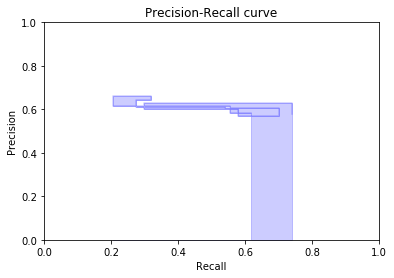

In [23]:
precisionArr = []
recallArr = []
def draw_pr_curve():
    print("precision",precisionArr)
    print("recall",recallArr)
    plt.step(recallArr, precisionArr, color='b', alpha=0.2,where='post')
    plt.fill_between(recallArr, precisionArr, step='post', alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title('Precision-Recall curve')

for i in np.linspace(0,1,10):
    p,r = train_NN(i)
    precisionArr.append(p)
    recallArr.append(r)
draw_pr_curve()

In [34]:
#All discrete except LF_Uncertain, LF_Treat_d
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(0,1),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.truncated_normal_initializer(2,0.2),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/500)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -4.19596636436
-0.00740213522486
[-1.25881212 -1.37197805 -0.32108058 -0.68485512  0.63440308  0.32260987
  0.11244719  1.5192371  -0.31654291  0.74345019  0.27964094 -0.68067538
  0.62097358 -0.33854728 -0.38364106  0.41908597 -0.73239456 -0.96374513
 -0.30413178 -0.73543352  0.11561932 -1.48559633 -0.28216542 -0.64650273
  1.13116083 -0.51429759  0.28483331 -0.76061032 -0.29306309 -1.23110396
  0.43013667 -0.26087358  1.16715996]
[ 2.01361038  2.13062515  2.149268    2.19906891  1.69563184  1.8730613
  1.86792618  2.15550721  1.85902501  2.05682444  2.26931316  2.09118371
  2.16697858  1.81766021  1.89376973  1.8947831   2.16073176  2.20083855
  2.10673363  1.82276522  1.84830885  1.79280005  2.21802156  1.97749951
  1.7908312   1.8710137   1.714827    1.92004859  2.0826906   1.64166262
  2.0563813   1.75587543  1.86782173]

503 385
0  d  (0.71016756603237718, 0.73226351351351349, 0.71300866976444788, None)
dev err: -4.20751978867
-0.776067689413
[-1.25941626 -1.3730436  -0

dev err: -4.32321864358
-0.872714685683
[-1.26384533 -1.39017325 -0.33615748 -0.69472754  0.62353162  0.31087754
  0.11002078  1.5192371  -0.33182495  0.73524025  0.26846524 -0.69555962
  0.62054059 -0.34424918 -0.38705147  0.41738055 -0.73239456 -0.97821609
 -0.31385286 -0.73543352  0.10853431 -1.55563201 -0.28216542 -0.64878644
  1.13116083 -0.51852585  0.28466411 -0.76040044 -0.29363452 -1.23181069
  0.42915914 -0.24219974  1.16715996]
[ 2.01925495  2.15086325  2.15856754  2.20664175  1.69800846  1.87733524
  1.86908023  2.15550721  1.8683825   2.05786419  2.27288491  2.10176839
  2.16705434  1.82186311  1.89626282  1.89530647  2.16073176  2.21376007
  2.11276474  1.82276522  1.85170777  1.88870672  2.21802156  1.97940133
  1.7908312   1.8744374   1.71489757  1.91985613  2.08304536  1.64262301
  2.05665227  1.74830771  1.86782173]

474 414
900  d  (0.72399559713813977, 0.75084459459459452, 0.72310863303649286, None)
dev err: -4.3395634446
-1.01540000745
[-1.26404726 -1.39275586 -0.3

dev err: -4.46070489581
-1.10217565599
[-1.26905075 -1.4052861  -0.34718326 -0.70603355  0.60976304  0.28905045
  0.10795454  1.5192371  -0.34418095  0.72515871  0.25820303 -0.70650907
  0.62032396 -0.35026652 -0.3900867   0.41718941 -0.73261063 -0.99619437
 -0.32224836 -0.73579598  0.09159484 -1.62038396 -0.28216542 -0.65173705
  1.13116083 -0.52312487  0.28477858 -0.76021955 -0.29456593 -1.23197494
  0.42809018 -0.23727873  1.16715996]
[ 2.02508925  2.1676454   2.1654095   2.21533649  1.70111338  1.88545535
  1.87006487  2.15550721  1.87571267  2.05918503  2.27620805  2.1094132
  2.16709227  1.82630734  1.89848405  1.89536495  2.160905    2.2298399
  2.1179954   1.82311032  1.85992034  1.97544549  2.21802156  1.98185973
  1.7908312   1.87816502  1.7148498   1.91969026  2.08362384  1.64284618
  2.05694897  1.74887592  1.86782173]

473 415
1800  d  (0.72317430398125271, 0.75, 0.72206572769953059, None)
dev err: -4.47674752217
-0.874937642156
[-1.27024625 -1.40658705 -0.3484827  -0.7069

dev err: -4.63123774183
-1.16000465312
[-1.27417666 -1.42488993 -0.36280877 -0.71493467  0.59908228  0.27197188
  0.10642693  1.5192371  -0.35978824  0.71905571  0.2475288  -0.72046439
  0.62032396 -0.35420498 -0.39293589  0.41846108 -0.73282672 -1.01397536
 -0.33231473 -0.73579598  0.08246193 -1.69873007 -0.28238716 -0.65603313
  1.13116083 -0.52923316  0.2839231  -0.76021955 -0.29409753 -1.23262586
  0.42819253 -0.21683905  1.16715996]
[ 2.03083108  2.18937834  2.17516464  2.22219833  1.70359477  1.89196007
  1.87079396  2.15550721  1.88543331  2.06000818  2.27970856  2.11982148
  2.16709227  1.82922104  1.90057117  1.89497409  2.16107826  2.24577158
  2.12429395  1.82311032  1.86439644  2.07825227  2.21814974  1.98544156
  1.7908312   1.8831219   1.7152067   1.91969026  2.08333277  1.64373043
  2.05692045  1.73999478  1.86782173]

472 416
2700  d  (0.72461701434159065, 0.75168918918918926, 0.72336740728225069, None)
dev err: -4.65378485276
-0.957276685891
[-1.27580195 -1.42642301 -0

dev err: -4.81890571827
-1.12048313205
[-1.27844085 -1.44578628 -0.37763104 -0.72288471  0.59051957  0.25270696
  0.10493852  1.5192371  -0.37471894  0.71103451  0.24019661 -0.7329962
  0.62032396 -0.36052857 -0.39616805  0.41729705 -0.73282672 -1.03100985
 -0.33844619 -0.73579598  0.07712151 -1.77791281 -0.2827352  -0.65906355
  1.13116083 -0.53431706  0.28384033 -0.76041521 -0.29428727 -1.23295462
  0.42607725 -0.20928502  1.16715996]
[ 2.03560516  2.21250037  2.18448136  2.22833916  1.70562965  1.89945496
  1.87150529  2.15550721  1.89483382  2.06111704  2.28213878  2.12870853
  2.16709227  1.83390728  1.90294123  1.89533147  2.16107826  2.26106026
  2.1281445   1.82311032  1.8670288   2.18009221  2.21835095  1.98796985
  1.7908312   1.88725262  1.71524122  1.91986967  2.08345051  1.64417696
  2.05750934  1.73836543  1.86782173]

453 435
3600  d  (0.73207733881403669, 0.76097972972972971, 0.72682109452215293, None)
dev err: -4.83749605952
-1.06936560846
[-1.2794567  -1.4486641  -0.3

In [28]:
#All discrete except LF_Uncertain, LF_Treat_d
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/500)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -0.761104545028
-0.00170363268645
[ 0.2         0.2         0.2         0.19998957  0.19998957  0.2         0.2
  0.2         0.2         0.19998957  0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.2         0.2
  0.19998957  0.20001043  0.2         0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.19998957  0.2       ]
[ 0.2         0.2         0.2         0.20004172  0.20004172  0.2         0.2
  0.2         0.2         0.20004172  0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.2         0.2
  0.20004172  0.19995828  0.2         0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.20002564  0.2       ]

624 264
0  d  (0.69675116550116556, 0.68496621621621623, 0.68963815789473693, None)
dev err: -0.761266114891
-0.148169988288
[ 0.19999959  0.19992509  0.19992509  0.19996877  0.19993368  0.19991299
  0.2    

In [24]:
#All discrete except LF_Uncertain 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.2),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/500)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -0.761104545028
-0.00170363268645
[ 0.2         0.2         0.2         0.19998957  0.19998957  0.2         0.2
  0.2         0.2         0.19998957  0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.2         0.2
  0.19998957  0.20001043  0.2         0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.19998957  0.2       ]
[ 0.2         0.2         0.2         0.20004172  0.20004172  0.2         0.2
  0.2         0.2         0.20004172  0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.2         0.2
  0.20004172  0.19995828  0.2         0.2         0.2         0.2         0.2
  0.2         0.2         0.2         0.2         0.20002564  0.2       ]

624 264
0  d  (0.69675116550116556, 0.68496621621621623, 0.68963815789473693, None)
dev err: -0.761266114891
-0.148169988288
[ 0.19999959  0.19992509  0.19992509  0.19996877  0.19993368  0.19991299
  0.2    

In [25]:
#All discrete  
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

def train_NN():
    print()
    result_dir = "./"
    config = projector.ProjectorConfig()
    tf.logging.set_verbosity(tf.logging.INFO)
    summary_writer = tf.summary.FileWriter(result_dir)

    tf.reset_default_graph()

    dim = 2 #(labels,scores)

    _x = tf.placeholder(tf.float64,shape=(dim,len(LFs)))

    alphas = tf.get_variable('alpha', _x.get_shape()[-1],initializer=tf.constant_initializer(0.5),
                            dtype=tf.float64)

    thetas = tf.get_variable('theta', _x.get_shape()[-1],initializer=tf.constant_initializer(0.5),
                            dtype=tf.float64)

    l,s = tf.unstack(_x)

    prelu_out_s = tf.maximum(tf.subtract(s,alphas), tf.zeros(shape=(len(LFs)),dtype=tf.float64))        

    mul_L_S = tf.multiply(l,prelu_out_s)

    phi_p1 = tf.reduce_sum(tf.multiply(mul_L_S,thetas))

    phi_n1 = tf.reduce_sum(tf.multiply(tf.negative(mul_L_S),thetas))

    phi_out = tf.stack([phi_n1,phi_p1])
    
    predict = tf.argmax(tf.nn.softmax(phi_out))

    loss = tf.negative(tf.reduce_logsumexp(phi_out))

    train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(loss) 


    check_op = tf.add_check_numerics_ops()

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(1):
        c = 0
        te_prev=1
        total_te = 0
        for L_S_i in train_L_S:

            a,t,te_curr,_ = sess.run([alphas,thetas,loss,train_step],feed_dict={_x:L_S_i})
            total_te+=te_curr

            if(abs(te_curr-te_prev)<1e-200):
                print("too low")
                break

            if(c%100==0):
                pl = []
                t_de=0
                for L_S_i in dev_L_S:
                    a,t,de_curr,p = sess.run([alphas,thetas,loss,predict],feed_dict={_x:L_S_i})
                    pl.append(p)
                    t_de+=de_curr
                predicted_labels = [-1 if x==0 else x for x in pl]
                print("dev err:",t_de/888)
                print(total_te/500)
                total_te=0
                print(a)
                print(t)
                print()
                print(predicted_labels.count(-1),predicted_labels.count(1))
                print(c," d ",precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
            c+=1
            te_prev = te_curr
        pl = []
        for L_S_i in dev_L_S:
            p = sess.run(predict,feed_dict={_x:L_S_i})
            pl.append(p)
        predicted_labels = [-1 if x==0 else x for x in pl]
        print(i,total_te)
        print(predicted_labels.count(-1),predicted_labels.count(1))
        print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average='macro'))
    
train_NN()


dev err: -0.837395683173
-0.00202983302024
[ 0.5         0.5         0.5         0.49996556  0.49996556  0.5         0.5
  0.5         0.5         0.49996556  0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5
  0.49996556  0.50003444  0.5         0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.49996556  0.5       ]
[ 0.5         0.5         0.5         0.50003444  0.50003444  0.5         0.5
  0.5         0.5         0.50003444  0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5         0.5
  0.50003444  0.49996556  0.5         0.5         0.5         0.5         0.5
  0.5         0.5         0.5         0.5         0.5000132   0.5       ]

624 264
0  d  (0.69675116550116556, 0.68496621621621623, 0.68963815789473693, None)
dev err: -0.837586450374
-0.159100591549
[ 0.49999     0.49977136  0.49977136  0.49989744  0.49978591  0.49971474
  0.5    